[2017-05-18 20:15:21,712] Making new env: CartPole-v1


episode: 0   score: 12.0   memory length: 13   epsilon: 0.9870777147137147
episode: 50   score: 9.0   memory length: 838   epsilon: 0.43239347672187917
episode: 100   score: 47.0   memory length: 2574   epsilon: 0.07613190441729188
episode: 150   score: 244.0   memory length: 5000   epsilon: 0.009998671593271896
episode: 200   score: 500.0   memory length: 5000   epsilon: 0.009998671593271896


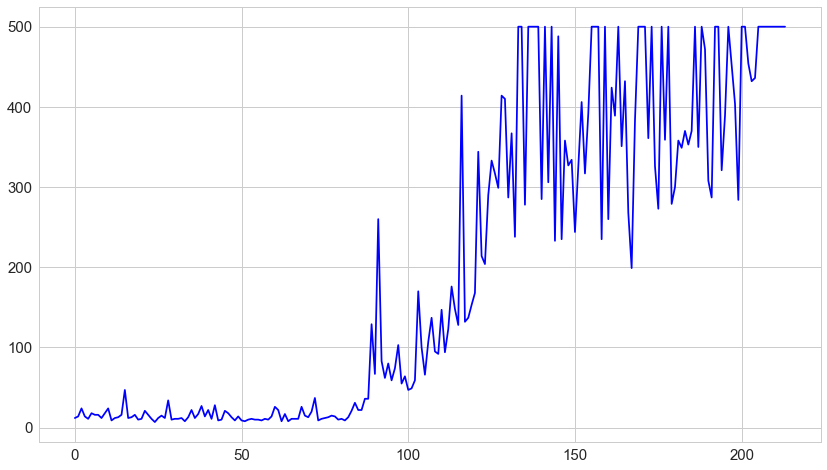

In [15]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

MAX_EPISODES = 1000

class DQNAgent:
    def __init__(self, state_size, action_size):

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=5000)

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def learn(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)

        for i in range(self.batch_size):
            # like Q Learning, get maximum Q value at s'
            # But from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * np.amax(target_val[i])

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

def train():
    # In case of CartPole-v1, you can play until 500 time step
    # get size of state and action from environment

    scores, episodes = [], []

    for e in range(MAX_EPISODES):
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False    
        while not done:

            # get action for the current state and go one step in environment
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            # save the sample <s, a, r, s'> to the replay memory
            agent.remember(state, action, reward, next_state, done)
            # every time step do the training
            agent.learn()
            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                
                if e % 50 == 0:
                
                    print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                          "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    plt.plot(episodes, scores, 'b')
                    return
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
train()

In [16]:
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


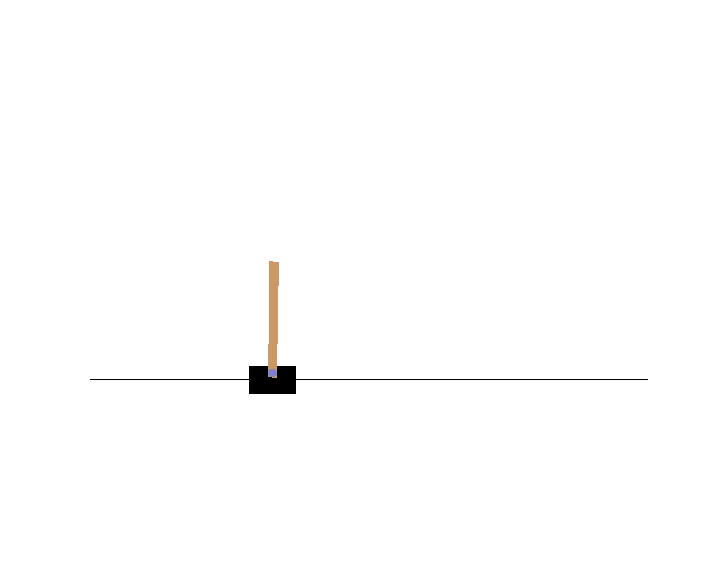

In [10]:
plot_environment(env)

In [11]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [18]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

state = env.reset()
state = np.reshape(state, [1, state_size])
done = False
frames = []
while not done:
    frames.append(env.render(mode='rgb_array'))
    action = agent.choose_action(state)
    state, reward, done, info = env.step(action)
    state = np.reshape(state, [1, state_size])
    if done:
        break

<IPython.core.display.Javascript object>


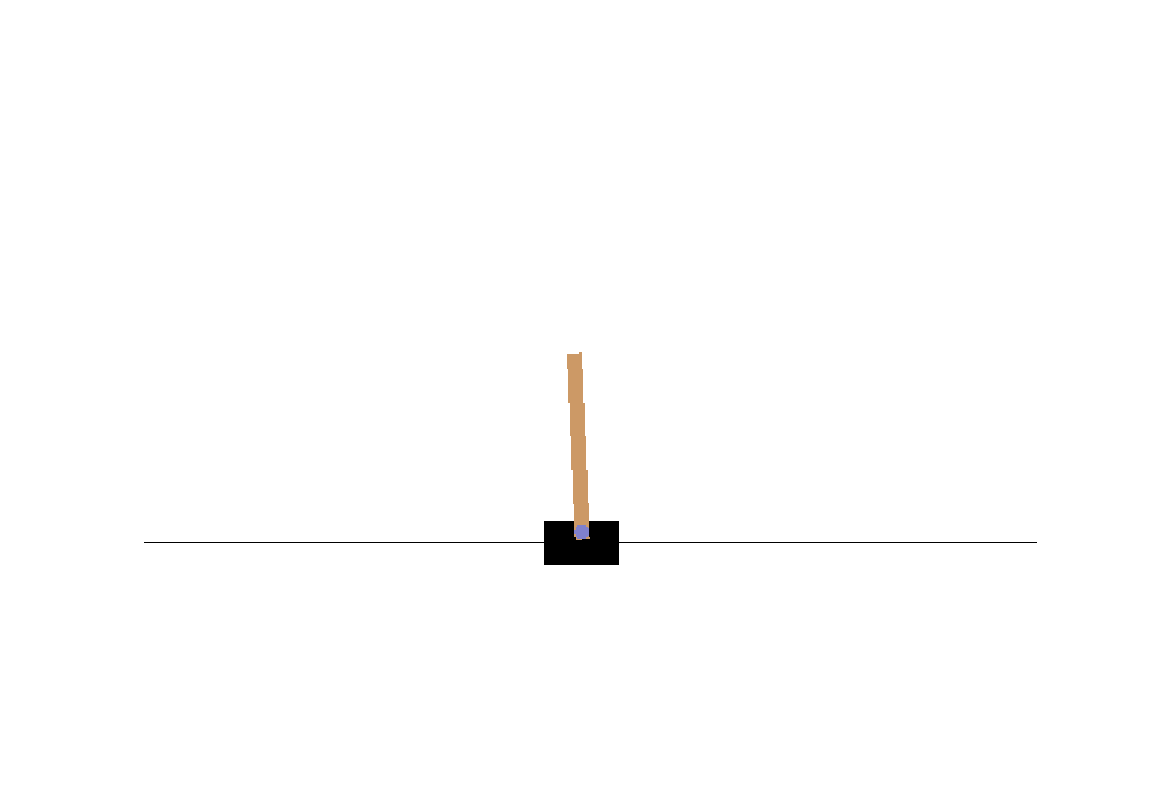

In [21]:
plot_animation(frames);